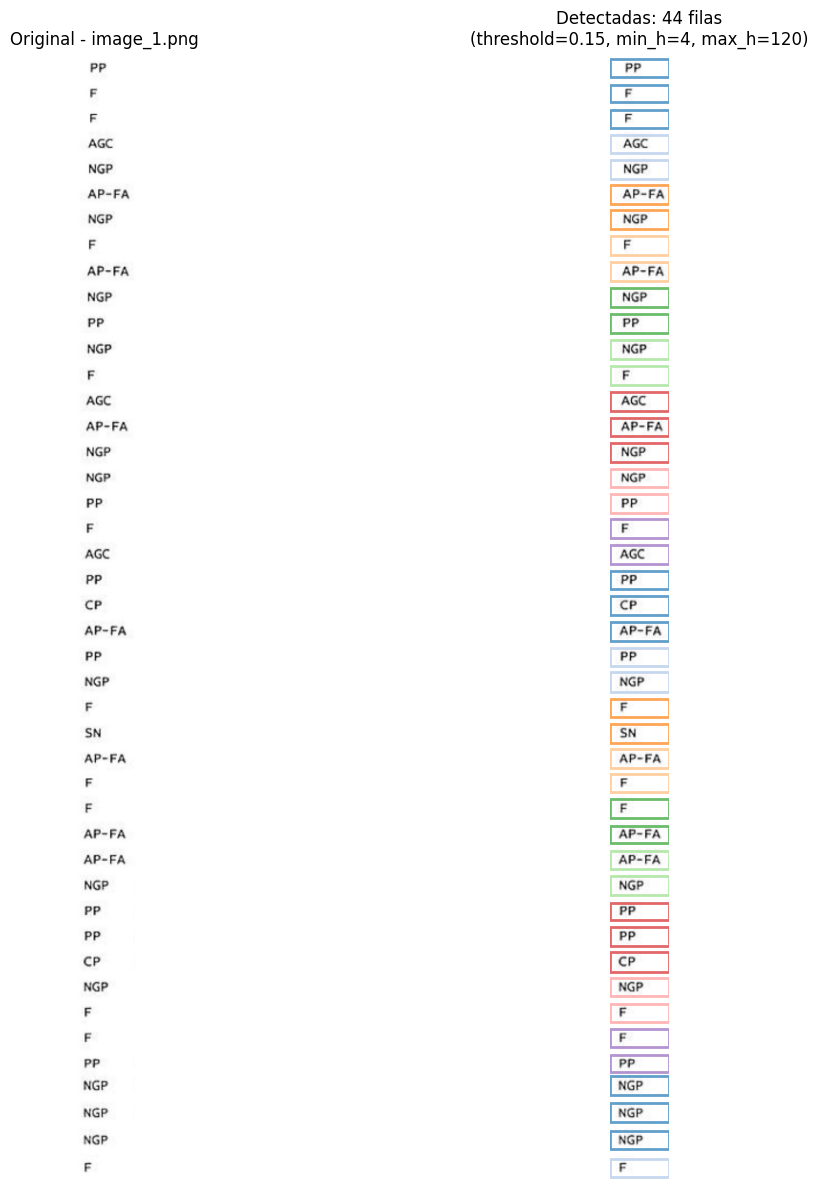

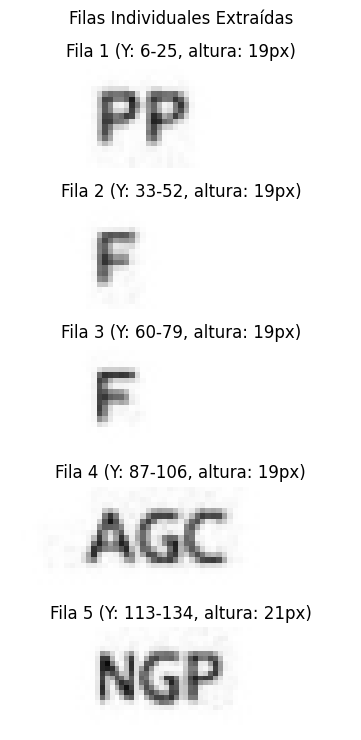


📊 RESUMEN - image_1.png
Filas detectadas: 44
Parámetros usados:
  - threshold_factor: 0.15
  - min_altura: 4px
  - max_altura: 120px
  - margen: 5px
Estadísticas de altura:
  - Mínima: 19px
  - Máxima: 21px
  - Promedio: 19.8px


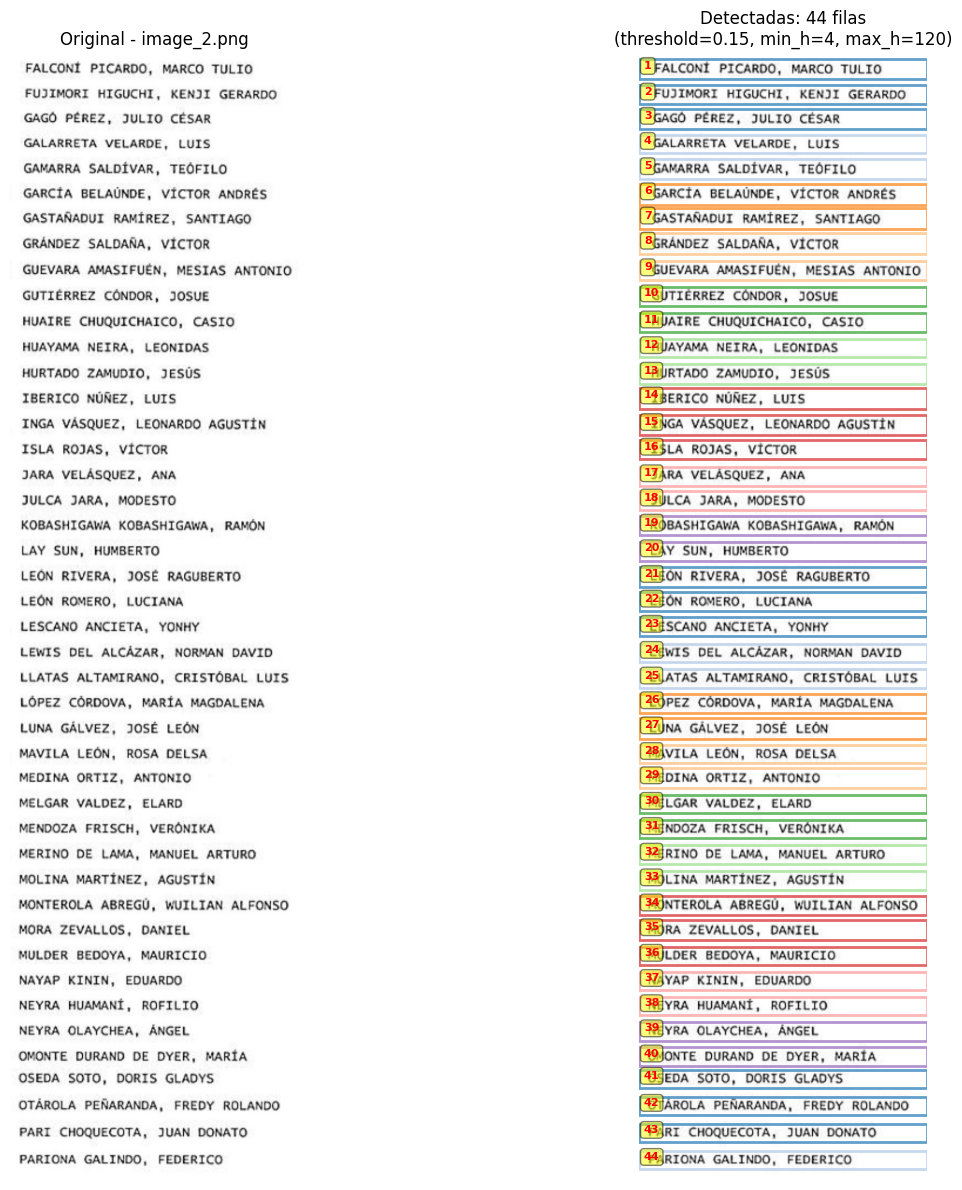

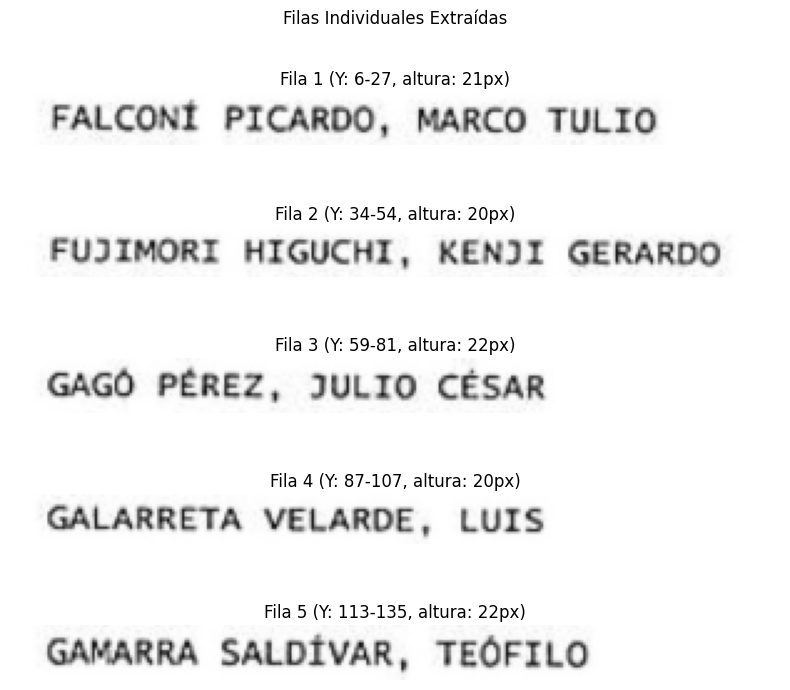


📊 RESUMEN - image_2.png
Filas detectadas: 44
Parámetros usados:
  - threshold_factor: 0.15
  - min_altura: 4px
  - max_altura: 120px
  - margen: 5px
Estadísticas de altura:
  - Mínima: 19px
  - Máxima: 22px
  - Promedio: 20.6px


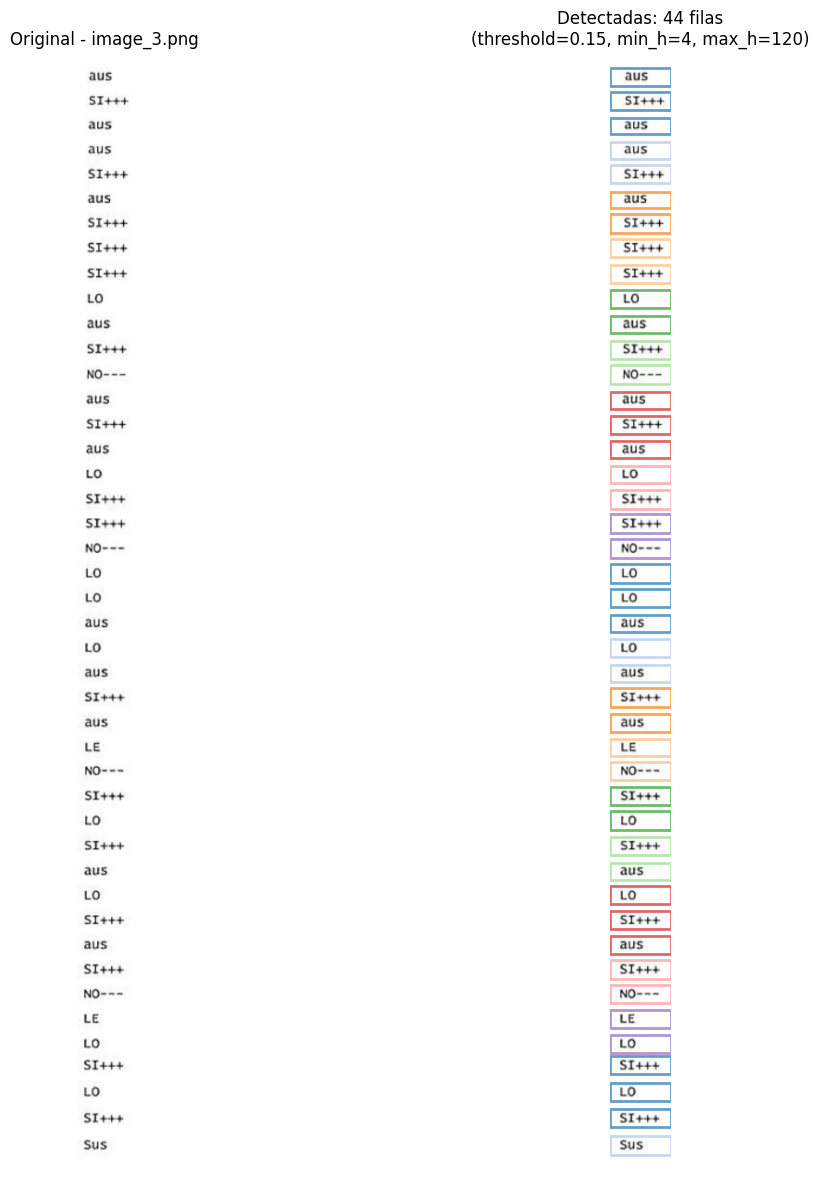

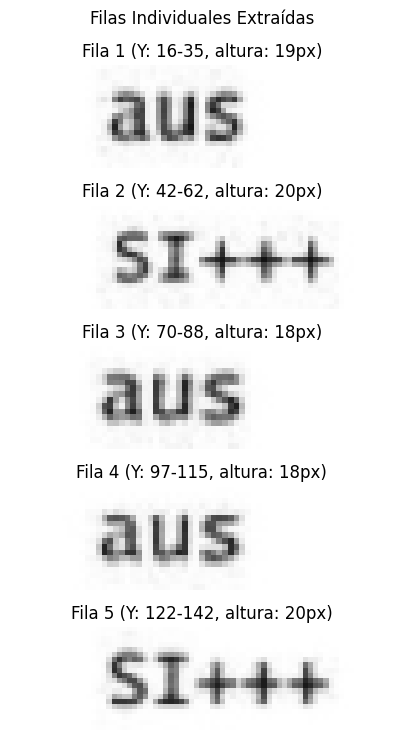


📊 RESUMEN - image_3.png
Filas detectadas: 44
Parámetros usados:
  - threshold_factor: 0.15
  - min_altura: 4px
  - max_altura: 120px
  - margen: 5px
Estadísticas de altura:
  - Mínima: 18px
  - Máxima: 21px
  - Promedio: 19.7px


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

def detectar_y_anotar_filas(image_path, 
                           annotation_path=None,
                           threshold_factor=0.3,
                           min_altura=10,
                           max_altura=100,
                           margen=2,
                           visualizar=True,
                           mostrar_filas_individuales=False,
                           max_filas_mostrar=5):
    """
    Función completa para detectar filas y generar anotaciones YOLO
    
    Parámetros:
    -----------
    image_path : str
        Ruta de la imagen a procesar
    annotation_path : str, optional
        Ruta donde guardar las anotaciones YOLO (si es None, no guarda)
    threshold_factor : float
        Factor para el threshold de detección (0.1-1.0, menor = más sensible)
    min_altura : int
        Altura mínima en píxeles para considerar una fila
    max_altura : int
        Altura máxima en píxeles para considerar una fila
    margen : int
        Píxeles adicionales arriba/abajo de cada fila
    visualizar : bool
        Si mostrar la visualización con matplotlib
    mostrar_filas_individuales : bool
        Si mostrar cada fila detectada por separado
    max_filas_mostrar : int
        Número máximo de filas individuales a mostrar
    
    Retorna:
    --------
    dict : Diccionario con:
        - 'filas': lista de diccionarios con las filas detectadas
        - 'total': número total de filas detectadas
        - 'anotaciones_yolo': lista de strings en formato YOLO
        - 'imagen_shape': tuple con (height, width, channels)
    """
    
    # Verificar que la imagen existe
    if not os.path.exists(image_path):
        print(f"❌ Error: No se encuentra la imagen {image_path}")
        return None
    
    # Cargar imagen
    imagen = cv2.imread(image_path)
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Binarización
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    
    # Proyección horizontal
    horizontal_projection = np.sum(binary, axis=1)
    
    # Calcular threshold
    threshold_projection = np.mean(horizontal_projection) * threshold_factor
    
    # Detectar inicio y fin de filas
    row_positions = []
    in_row = False
    start_y = 0
    
    for y in range(len(horizontal_projection)):
        if horizontal_projection[y] > threshold_projection:
            if not in_row:
                start_y = y
                in_row = True
        else:
            if in_row:
                if y - start_y > min_altura:
                    row_positions.append((start_y, y))
                in_row = False
    
    # Cerrar última fila si quedó abierta
    if in_row and len(horizontal_projection) - start_y > min_altura:
        row_positions.append((start_y, len(horizontal_projection)))
    
    # Crear bounding boxes
    filas = []
    for start_y, end_y in row_positions:
        y1 = max(0, start_y - margen)
        y2 = min(imagen.shape[0], end_y + margen)
        altura = y2 - y1
        
        if min_altura < altura < max_altura:
            filas.append({
                'x': 0,
                'y': y1,
                'width': imagen.shape[1],
                'height': altura,
                'bbox': (0, y1, imagen.shape[1], altura)
            })
    
    # Generar anotaciones YOLO
    anotaciones_yolo = []
    for fila in filas:
        x_center = (fila['x'] + fila['width']/2) / imagen.shape[1]
        y_center = (fila['y'] + fila['height']/2) / imagen.shape[0]
        width = fila['width'] / imagen.shape[1]
        height = fila['height'] / imagen.shape[0]
        anotaciones_yolo.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    # Guardar anotaciones si se especificó path
    if annotation_path:
        os.makedirs(os.path.dirname(annotation_path) if os.path.dirname(annotation_path) else '.', exist_ok=True)
        with open(annotation_path, 'w') as f:
            f.write('\n'.join(anotaciones_yolo))
        print(f"✅ Anotaciones guardadas en: {annotation_path}")
    
    # Visualización
    if visualizar:
        # Calcular el tamaño de figura basado en el tamaño de la imagen
        fig_width = min(15, max(8, imagen.shape[1] / 100))
        fig_height = min(12, max(6, imagen.shape[0] / 100))
        
        fig, axes = plt.subplots(1, 2, figsize=(fig_width*2, fig_height))
        
        # Imagen original
        axes[0].imshow(imagen_rgb)
        axes[0].set_title(f'Original - {os.path.basename(image_path)}')
        axes[0].axis('off')
        
        # Imagen con detecciones
        axes[1].imshow(imagen_rgb)
        axes[1].set_title(f'Detectadas: {len(filas)} filas\n' + 
                         f'(threshold={threshold_factor:.2f}, min_h={min_altura}, max_h={max_altura})')
        axes[1].axis('off')
        
        # Dibujar rectángulos
        colores = plt.cm.tab20(np.linspace(0, 1, max(len(filas), 1)))
        
        for idx, fila in enumerate(filas):
            rect = Rectangle(
                (fila['x'], fila['y']), 
                fila['width'], 
                fila['height'],
                linewidth=2, 
                edgecolor=colores[idx % 20], 
                facecolor='none',
                alpha=0.7
            )
            axes[1].add_patch(rect)
            
            # Añadir número si la imagen es suficientemente ancha
            if imagen.shape[1] > 150:
                axes[1].text(
                    fila['x'] + 5, 
                    fila['y'] + fila['height']/2, 
                    f"{idx+1}", 
                    color='red', 
                    fontsize=8, 
                    fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5)
                )
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar filas individuales si se solicita
        if mostrar_filas_individuales and len(filas) > 0:
            num_filas_mostrar = min(len(filas), max_filas_mostrar)
            fig, axes = plt.subplots(num_filas_mostrar, 1, 
                                   figsize=(fig_width, num_filas_mostrar * 1.5))
            
            if num_filas_mostrar == 1:
                axes = [axes]
            
            for idx in range(num_filas_mostrar):
                fila = filas[idx]
                y1 = fila['y']
                y2 = fila['y'] + fila['height']
                fila_img = imagen_rgb[y1:y2, :]
                
                axes[idx].imshow(fila_img)
                axes[idx].set_title(f'Fila {idx+1} (Y: {y1}-{y2}, altura: {fila["height"]}px)')
                axes[idx].axis('off')
            
            plt.suptitle('Filas Individuales Extraídas')
            plt.tight_layout()
            plt.show()
    
    # Imprimir resumen
    print(f"\n📊 RESUMEN - {os.path.basename(image_path)}")
    print("="*50)
    print(f"Filas detectadas: {len(filas)}")
    print(f"Parámetros usados:")
    print(f"  - threshold_factor: {threshold_factor}")
    print(f"  - min_altura: {min_altura}px")
    print(f"  - max_altura: {max_altura}px")
    print(f"  - margen: {margen}px")
    
    if len(filas) > 0:
        alturas = [f['height'] for f in filas]
        print(f"Estadísticas de altura:")
        print(f"  - Mínima: {min(alturas)}px")
        print(f"  - Máxima: {max(alturas)}px")
        print(f"  - Promedio: {np.mean(alturas):.1f}px")
    
    # Retornar resultados
    return {
        'filas': filas,
        'total': len(filas),
        'anotaciones_yolo': anotaciones_yolo,
        'imagen_shape': imagen.shape,
        'parametros': {
            'threshold_factor': threshold_factor,
            'min_altura': min_altura,
            'max_altura': max_altura,
            'margen': margen
        }
    }


# ============= EJEMPLOS DE USO =============

# Ejemplo 1: Imagen de grupo parlamentario
resultado = detectar_y_anotar_filas(
    image_path='image_1.png',
    annotation_path=None,
    threshold_factor=0.15,
    min_altura=4,
    max_altura=120,
    visualizar=True,
    mostrar_filas_individuales=True,
    margen=5
)

# Ejemplo 2: Imagen de congresistas
resultado = detectar_y_anotar_filas(
    image_path='image_2.png',
    annotation_path=None,
    threshold_factor=0.15,
    min_altura=4,
    max_altura=120,
    visualizar=True,
    mostrar_filas_individuales=True,
    margen=5
)

# Ejemplo 3: Imagen de votos
resultado = detectar_y_anotar_filas(
    image_path='image_3.png',
    annotation_path=None,
    threshold_factor=0.15,
    min_altura=4,
    max_altura=120,
    visualizar=True,
    mostrar_filas_individuales=True,
    margen=5
)